# Naive Bayes (NB), Logistic Regression (LR)
***

Imports

In [28]:
import numpy as np
import math
from xml.dom import minidom
from xml.etree import cElementTree as ElementTree
import os
import nltk
import pickle
import csv
import timeit
import re
import warnings
warnings.filterwarnings('ignore')
from scipy.sparse import hstack
from sklearn.datasets import make_classification
import pandas as pd
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import recall_score, make_scorer, precision_score
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\diego\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\diego\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\diego\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

#### File reading

In [29]:
def printExecTime(func):
    """
    Decorator definition for printing the execution time of a function. 
    :param func. Function for which to measure execution time.
    """
    def wrapper(*args, **kwargs):
        init_time = timeit.default_timer()
        result = func(*args, **kwargs)
        stop_time = timeit.default_timer()
        total = stop_time - init_time
        print('Execution time in sec for', func.__name__, 'was', total)
        return result
    return wrapper


In [30]:
CLASSES = {}

@printExecTime
def documentReader(path):
    global CLASSES
    documents_path = os.path.join(os.getcwd(), path)
    docs = {}
    id = 1
    for dir_name in os.listdir(documents_path):
        CLASSES[id] = dir_name
        CLASSES[dir_name] = id
        class_path = os.path.join(documents_path, dir_name)

        for document in os.listdir(class_path):
            document_path = os.path.join(class_path, document)
            file = open(document_path, 'r').read()
            docs[str(id) + '-' + document] = file.replace(u'\xa0', u' ').replace('\n', ' ')
        id += 1
    return docs

raw_docs = documentReader('datasets/20news')
print('Count', len(raw_docs), 'docs read')
print('CLASSES and ids', list(CLASSES.items())[:2])

Execution time in sec for documentReader was 2.4240606000003027
Count 18828 docs read
CLASSES and ids [(1, 'alt.atheism'), ('alt.atheism', 1)]


### Proccessing pipeline

In [31]:

def regexPipeFilter(text):
    stop_words = set(nltk.corpus.stopwords.words("english"))
    lemmatizer = nltk.stem.WordNetLemmatizer()

    # Remove all the special characters
    document = re.sub(r'\W', ' ', text)

    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

    # Converting to Lowercase
    document = document.lower()

    # Lemmatization
    document = document.split()

    document = [lemmatizer.lemmatize(word) for word in document if word not in stop_words]
    document = ' '.join(document)
    return document

@printExecTime
def proccessDocs(docs): 
    """
    Proccesing pipiling for the raw docs read from files
    :param docs: Dictionary containing the raw docs previously read from files
    :return: 
    """
    getClass = lambda x: int(x.split('-')[0])
    proccessed_docs = [[regexPipeFilter(document), getClass(key), key] for key, document in docs.items()]

    return proccessed_docs

tokenized_docs = proccessDocs(raw_docs)

Execution time in sec for proccessDocs was 21.767163299999993


In [32]:
print(tokenized_docs[0][1])
print('Class:', CLASSES[tokenized_docs[0][1]], '.', tokenized_docs[0][0][:100])

1
Class: alt.atheism . mathew mathew mantis co uk subject alt atheism faq atheist resource archive name atheism resource al


#### Dataset division

In [33]:
@printExecTime
def divideSets(tokenized_docs,):
    train, test = 0.7, 0.3
    # test_ratio, dev_ratio = test/(dev+test), dev/(dev+test)
    total = len(tokenized_docs)

    train_set, test_set = train_test_split(tokenized_docs, test_size= test, train_size=train)
    # dev_set, test_set = train_test_split(rest, test_size=test_ratio, train_size= dev_ratio)

    print('Train', len(train_set)/total)
    print('Test', len(test_set)/total)
    # print('Dev', len(dev_set)/total)

    return train_set, test_set

train_set, test_set= divideSets(tokenized_docs)

Train 0.699968132568515
Test 0.300031867431485
Execution time in sec for divideSets was 0.00870279999980994


In [34]:
def extractXY(dataset):
    """
    Extracts individual vectors for documents and document's classes.
    """
    x , y= [], []
    for [x_i,  y_i, _] in dataset:
        x.append(x_i)
        y.append(y_i)
    return x, y

train_x, train_y = extractXY(train_set)
# dev_x, dev_y = extractXY(dev_set)
test_x, test_y = extractXY(test_set)

In [35]:
print(train_y[0])
print(train_x[0][:100])

16
stovall ficus c ucla edu steven stovall subject rebuilding temple anybody tcsteven iaserv b1 ingr co


## Feature Extraction from training set

* BOW

In [36]:
@printExecTime
def bowBuilder(docs, max_features=None, min_df=1, max_df=1, binary=False):

    vectorizer = CountVectorizer(max_features=max_features, binary=binary)
    docs_bow = vectorizer.fit_transform(docs)
    return docs_bow, vectorizer

train_bow, vectorizer = bowBuilder(train_x, max_features=50000)
print(train_bow.shape)

Execution time in sec for bowBuilder was 1.905274300000201
(13179, 50000)


Transform `test` and `dev` to *BOW* using vocabulary from `train`  set

In [37]:
# dev_bow = vectorizer.transform(dev_x)
test_bow = vectorizer.transform(test_x)
# print("Shape dev", dev_bow.shape)
print("Shape test", test_bow.shape)

Shape test (5649, 50000)


In [38]:
# print(train_bow.todense()[0].sum())
# vectorizer.get_feature_names()[30000:30200]
frequency_matrix = pd.DataFrame(train_bow.toarray(),
                                columns = vectorizer.get_feature_names())

In [39]:
frequency_matrix.iloc[0].sum()
# train_set[0][2]
# CLASSES[12]
# print('good' in vectorizer.get_feature_names())
# train_x[0]
# vectorizer.inverse_transform(train_bow)

110

* Binary BOW representation

In [40]:
train_bool, bool_vectorizer = bowBuilder(train_x, binary=True)
# dev_bool = bool_vectorizer.transform(dev_x)
test_bool = bool_vectorizer.transform(test_x)

print("Shape bin train", train_bool.shape)
# print("Shape bin dev", dev_bool.shape)
print("Shape bin test", test_bool.shape)

Execution time in sec for bowBuilder was 1.9836810000006153
Shape bin train (13179, 141112)
Shape bin test (5649, 141112)


## Training models on 60% training set

### Logistic Regression.

We will evaluate some multinomial logistic Regressions with different hyperparameters seen in class such as a bias,
class weights, and other not seen but popular sucha as L2 penalty.
. Specifically, we will test the following
parameter combinations:

- L2 penalty: 0.1, class_weight: 'Balanced'
- L2 penalty: 0.5, class_weight: 'Balanced'
- L2 penalty: 1.0, class_weight: None (All have same weight: 1)

In this case we will use default hyperparameters of the Sklearn implementation of the Multinomial Logistic Regression.

The next step will include the hyperparameter search using 10-Fold cross Validation

In [41]:
def model(penalty=1, class_weight=None, solver='lbfgs'):
    classifier = LogisticRegression(multi_class='multinomial', solver=solver,
                                    C=penalty, class_weight=class_weight, n_jobs=6)
    return classifier

def saveModel(model, filename, folder='datasets'):
    path = os.path.join(os.getcwd(), folder, filename)
    with open(path, 'wb') as picklefile:
        pickle.dump(model, picklefile)

def readModel(filename, folder='datasets'):
    path = os.path.join(os.getcwd(), folder, filename)
    with open(path, 'rb') as model:
        return pickle.load(model)

saveModel(train_set, 'train_set')
saveModel(train_y, 'train_y')
saveModel(train_bow, 'train_bow')

Definición de modelos a entrenar

In [42]:
def getLRModels(solver='sag', repr='bow'):
    models = {}
    penalties = [0.01, 0.1, 0.5, 1]
    class_weights = ['balanced', None]
    for c in penalties:
        for w in class_weights:
            key = f'c-{c}-w-{w}-LR-{repr}'
            models[key] = model(penalty=c, class_weight=w, solver=solver)
    return models

def evaluate_model(model, X, y, metrics=['accuracy']):
    cv = KFold(n_splits=10)
    scores = cross_validate(model, X, y, scoring=metrics, cv=cv, n_jobs=-1)
    return scores


Cross validate BOW representation

In [43]:
@printExecTime
def crossValidateModels(models, X, y, metrics=['accuracy']):
    results, names = [], []
    for name, model in models.items():
        scores = evaluate_model(model, X, y, metrics=metrics)
        results.append(scores)
        names.append(name)
        print('Got result for:', name)
    return results, names

def getPerClassScorings():
    recall = {f'recall-{i}': make_scorer(recall_score, average=None, labels=[i]) for i in range(1, 21)}
    precision = {f'precision-{i}': make_scorer(precision_score, average=None, labels=[i]) for i in range(1, 21)}
    scoring = recall.copy()
    scoring.update(precision)
    return scoring


In [44]:
bow_results, names = crossValidateModels(getLRModels(), train_bow, train_y, metrics=getPerClassScorings())

Got result for: c-0.01-w-balanced-LR-bow
Got result for: c-0.01-w-None-LR-bow
Got result for: c-0.1-w-balanced-LR-bow
Got result for: c-0.1-w-None-LR-bow
Got result for: c-0.5-w-balanced-LR-bow
Got result for: c-0.5-w-None-LR-bow
Got result for: c-1-w-balanced-LR-bow
Got result for: c-1-w-None-LR-bow
Execution time in sec for crossValidateModels was 503.2952293999997


In [59]:
saveModel(bow_results, 'bow_results_LR')
bow_results = readModel('bow_results_LR')
print(names[0] ,len(bow_results[0]))
# X, y = make_classification(n_samples=100, n_features=20, n_informative=15, n_redundant=5, random_state=1, n_classes=3)
# model = list(getLRModels().values())[0]
# scores = cross_validate(model, X, y, cv=5, scoring=('f1_macro','accuracy','precision_macro','recall_macro'))

alpha-0.01-fp-T-NB-bool 42


Cross validation binary BOW representation Linear Regression

In [46]:
bow_bool_results, names = crossValidateModels(getLRModels(repr='bool'), train_bool, train_y, metrics=getPerClassScorings())

Got result for: c-0.01-w-balanced-LR-bool
Got result for: c-0.01-w-None-LR-bool
Got result for: c-0.1-w-balanced-LR-bool
Got result for: c-0.1-w-None-LR-bool
Got result for: c-0.5-w-balanced-LR-bool
Got result for: c-0.5-w-None-LR-bool
Got result for: c-1-w-balanced-LR-bool
Got result for: c-1-w-None-LR-bool
Execution time in sec for crossValidateModels was 607.7409595000008


In [58]:
saveModel(bow_bool_results, 'bow_bool_results_LR')
bow_bool_results = readModel('bow_bool_results_LR')
print(names[0] ,len(bow_bool_results[0]))

alpha-0.01-fp-T-NB-bool 42


### Naive Bayes

In [48]:
def NBmodel(alpha, fit_prior):
    return MultinomialNB(alpha=alpha, fit_prior=fit_prior)

def getBayesModels(repr='bow'):
    smoothing = [0.01, 0.1, 0.5, 1]
    fit_prior = [True, False]
    models = {}
    for a in smoothing:
        for b in fit_prior:
            bin = str(b)[0]
            key = f'alpha-{a}-fp-{bin}-NB-{repr}'
            models[key] = NBmodel(alpha=a, fit_prior=b)
    return models

Cross validation BOW representation Naive Bayes

In [49]:
bow_results_NB, names = crossValidateModels(getBayesModels(),
                                            train_bow, train_y, metrics=getPerClassScorings())

Got result for: alpha-0.01-fp-T-NB-bow
Got result for: alpha-0.01-fp-F-NB-bow
Got result for: alpha-0.1-fp-T-NB-bow
Got result for: alpha-0.1-fp-F-NB-bow
Got result for: alpha-0.5-fp-T-NB-bow
Got result for: alpha-0.5-fp-F-NB-bow
Got result for: alpha-1-fp-T-NB-bow
Got result for: alpha-1-fp-F-NB-bow
Execution time in sec for crossValidateModels was 6.210496800000328


Cross validation binary BOW representation Naive Bayes

In [50]:
bow_boolNB_results, names = crossValidateModels(getBayesModels(repr='bool'),
                                                train_bool, train_y, metrics=getPerClassScorings())

Got result for: alpha-0.01-fp-T-NB-bool
Got result for: alpha-0.01-fp-F-NB-bool
Got result for: alpha-0.1-fp-T-NB-bool
Got result for: alpha-0.1-fp-F-NB-bool
Got result for: alpha-0.5-fp-T-NB-bool
Got result for: alpha-0.5-fp-F-NB-bool
Got result for: alpha-1-fp-T-NB-bool
Got result for: alpha-1-fp-F-NB-bool
Execution time in sec for crossValidateModels was 7.720110199999908


## Cross Validation Metrics

Here we will use a 10-fold cross validation strategy over the `train`+`dev` sets to evaluate the bests hyperparameters
for our models from a chosen subset of all the possibles hyperparameters combinations

In [51]:
def meanOfScores(scores, score_keys):
    avg_recalls, avg_precisions = [], []
    for key in score_keys:
        avgs = np.mean(scores['test_' + key])
        if 'recall' in key:
            avg_recalls.append(avgs)
        else:
            avg_precisions.append(avgs)
    return avg_recalls, avg_precisions


def modelsPerScore(scoresPerModels):
    all_recalls = []
    all_precisions = []

    for model_scores in scoresPerModels:
        avg_recalls, avg_precisions = meanOfScores(model_scores, getPerClassScorings().keys())
        all_recalls.append(avg_recalls)
        all_precisions.append(avg_precisions)

    return all_recalls, all_precisions


def graphMetrics(all_recalls, all_precisions, model_names):
    plt.rcParams["figure.figsize"] = (18,10)
    plt.subplot(2, 1, 1)
    plt.boxplot(all_recalls, showmeans=True, labels=model_names)
    plt.title('Boxplot of recalls distribution per class in various models')
    plt.xlabel('Models')
    plt.legend()
    plt.grid(0.2)

    plt.subplot(2, 1, 2)
    plt.boxplot(all_precisions, showmeans=True, labels=model_names)
    plt.title('Boxplot of precision distribution per class in various models')
    plt.xlabel('Models')
    plt.legend()
    plt.grid(0.2)
    plt.tight_layout()
    plt.show()

Here we get for each model, average recall and precision per class. This is used to graph a box plot from the metrics
distributions for the classes in each model.

*Note:* The model names correspond to the tyoe of model, its hyperparameters, and the document representation beeing
used for the cross validation.

In [52]:
bow_recalls, bow_precisions = modelsPerScore(bow_results)
bow_bool_recalls, bow_bool_precisions = modelsPerScore(bow_bool_results)

### Graph

#### Logistic Regression

* **BOW - Logistic Regression**. Distribution of class metrics in `train`+`dev` sets

No handles with labels found to put in legend.
No handles with labels found to put in legend.


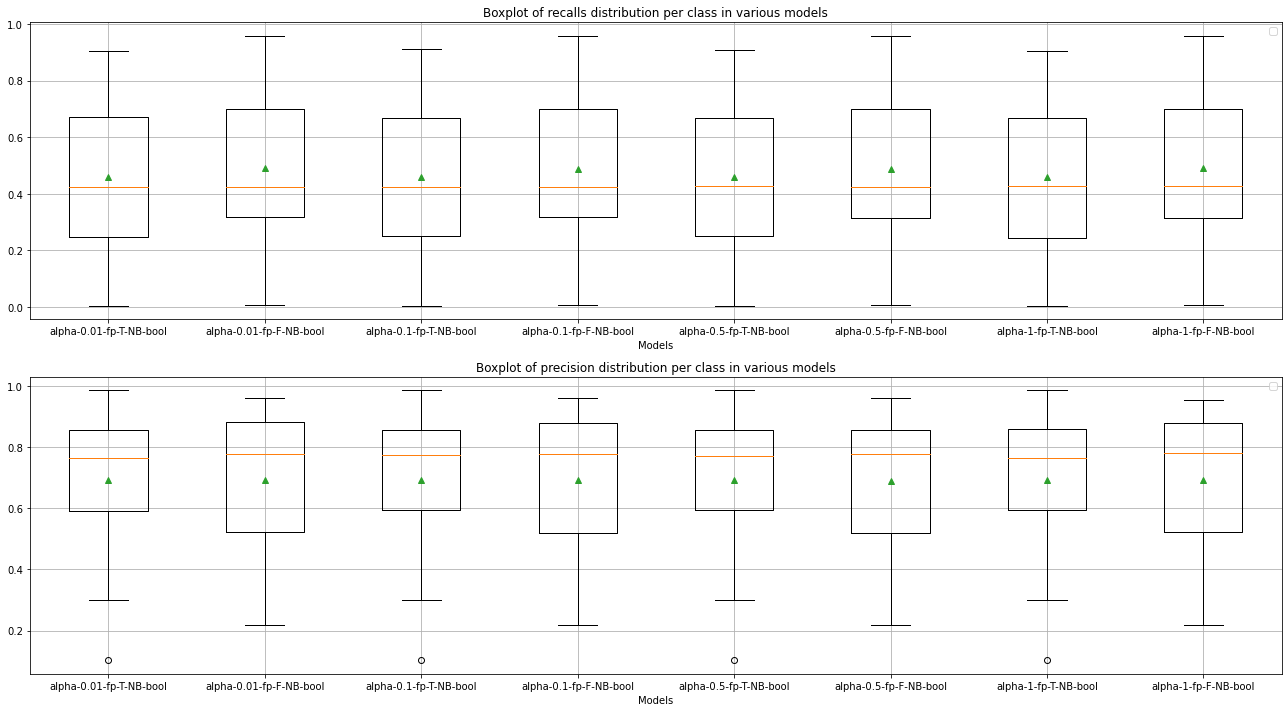

In [53]:
graphMetrics(bow_recalls, bow_precisions, names)

* **Binary BOW - Logistic Regression**. Distribution of class metrics in `train`+`dev` sets

No handles with labels found to put in legend.
No handles with labels found to put in legend.


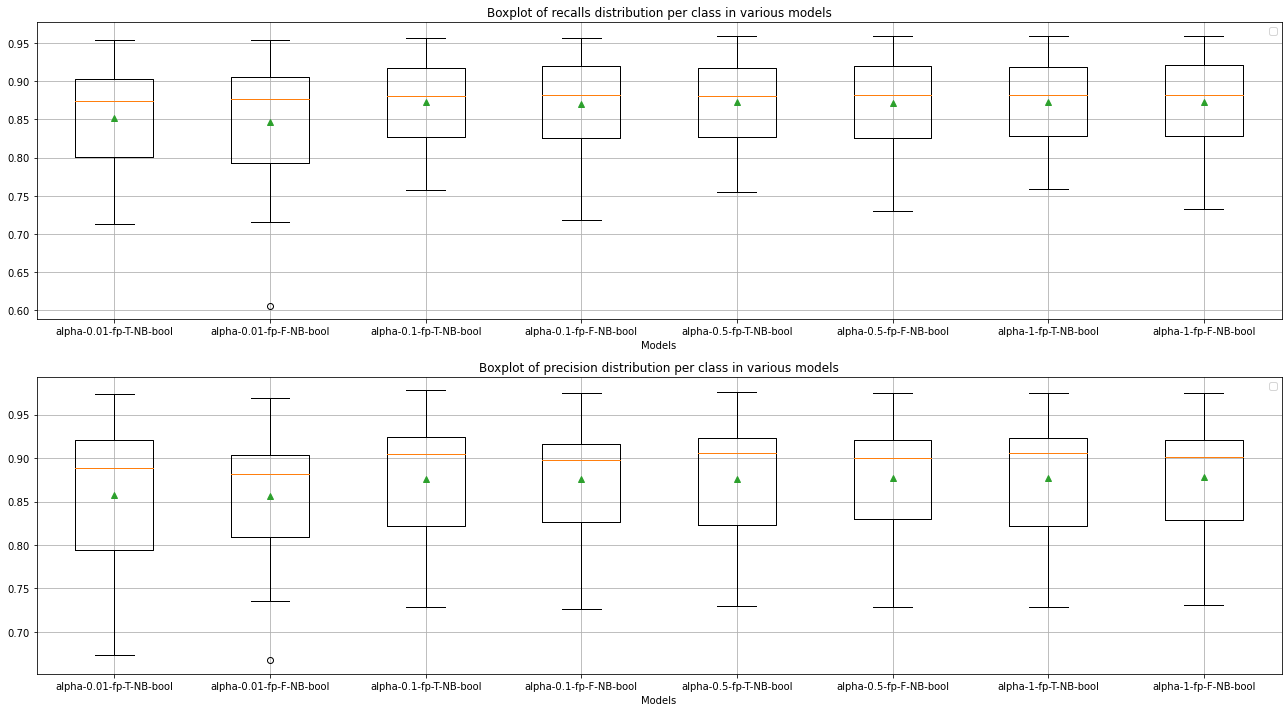

In [54]:
graphMetrics(bow_bool_recalls, bow_bool_precisions, names)

* **Custom repr - Logistic Regression**. Distribution of class metrics in `train`+`dev` sets

### Graph

#### Naive Bayes

In [55]:
bow_recalls_NB, bow_precisions_NB = modelsPerScore(bow_results_NB)
bow_bool_recalls_NB, bow_bool_precisions_NB = modelsPerScore(bow_boolNB_results)

* **BOW - Naive Bayes**. Distribution of class metrics in `train`+`dev` sets

No handles with labels found to put in legend.
No handles with labels found to put in legend.


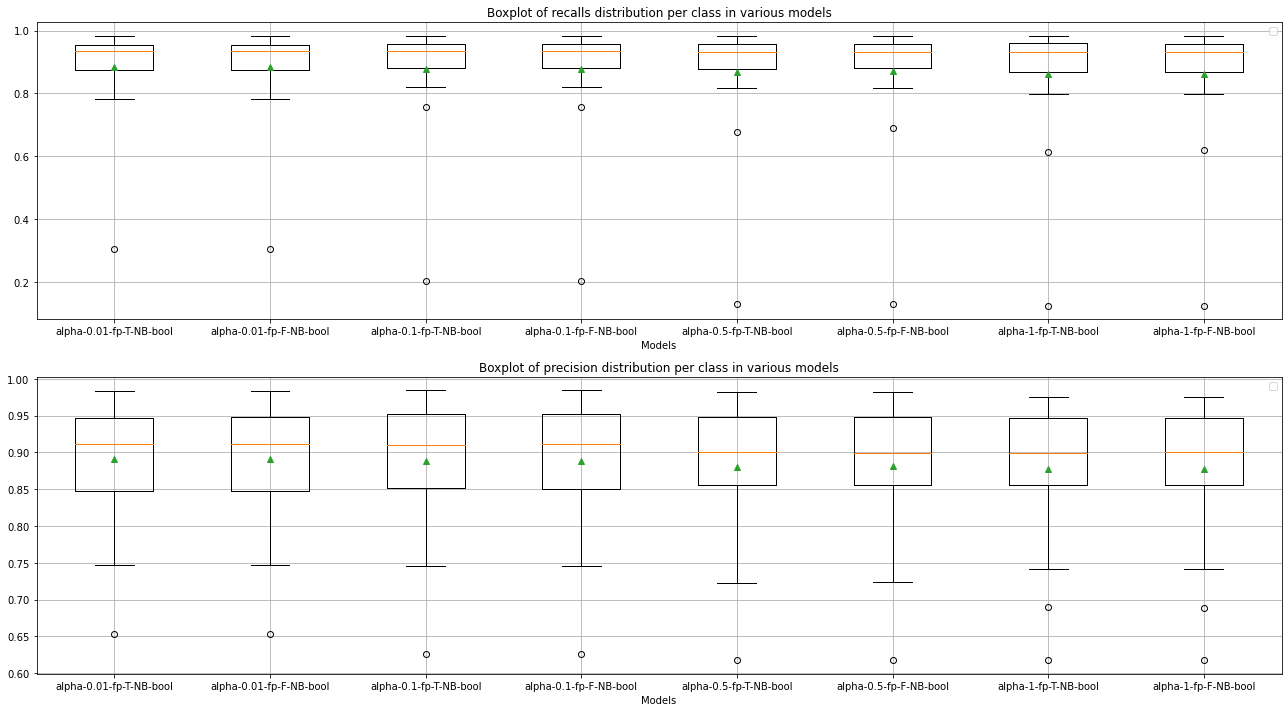

In [56]:
graphMetrics(bow_recalls_NB, bow_precisions_NB, names)

* **Binary BOW - Logistic Regression**. Distribution of class metrics in `train`+`dev` sets

No handles with labels found to put in legend.
No handles with labels found to put in legend.


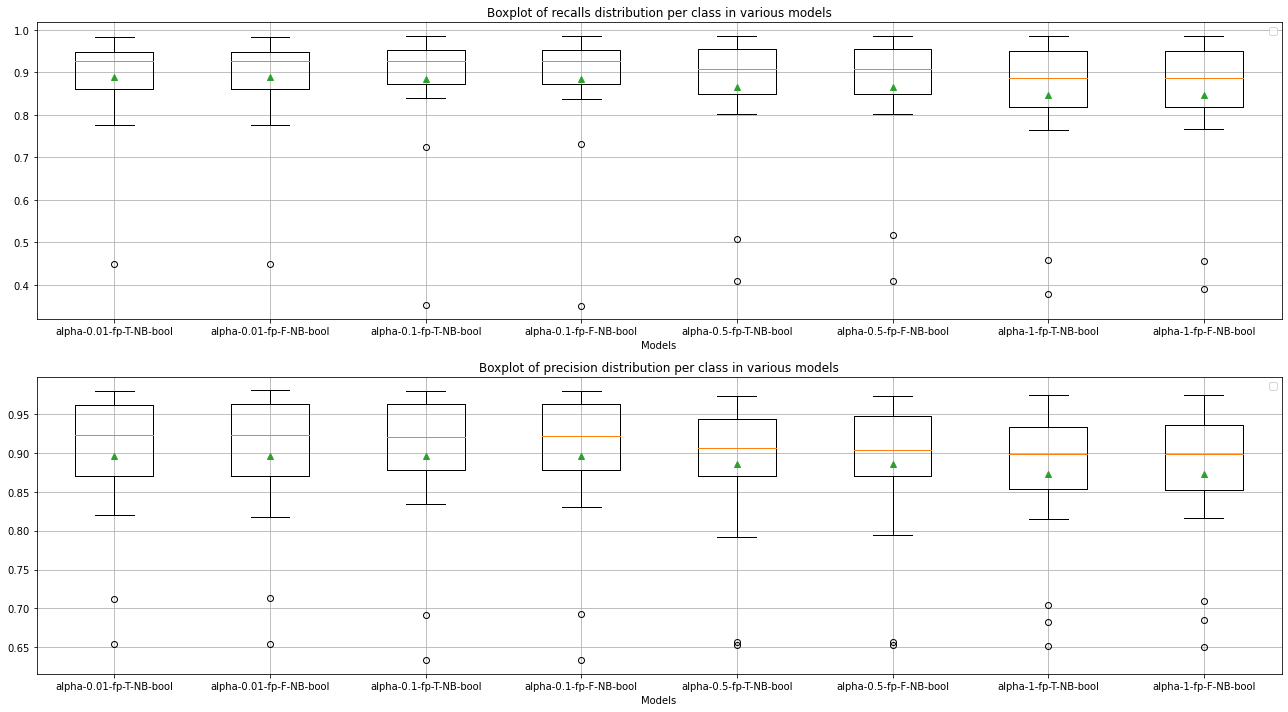

In [57]:
graphMetrics(bow_bool_recalls_NB, bow_bool_precisions_NB, names)

* **Custom repr - Logistic Regression**. Distribution of class metrics in `train`+`dev` sets